## [Dataset과 Dataloader](https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html)
> 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있습니다. 
> 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다.
> `Dataset`은 샘풀과 정답을 저장하고, `DataLoader`는 `Dataset`을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.  
  
#### torch.utils.data.Dataset
> 이미지 데이터셋, 텍스트 데이터셋 및 오디오 데이터셋

### 데이터셋 불러오기
> TorchVision에서 `Fashion-MNIST` 데이터셋을 불러오는 예제를 살펴보겠습니다. Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있습니다.  
> 각 예제는 흑백(grayscale)의 28 x 28 이미지와 10개 분류 중 하나인 정답으로 구성됩니다.  
  
다음 매개 변수들을 사용하여 Fashion-MNIST 데이터셋을 불러옵니다.
- root는 학습/테스트 데이터가 저장되는 경로입니다. 
- train은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.
- download=True는 root에 데이터가 없는 경우 인터넷에서 다운로드합니다.
- transform과 target_transform은 특징과 정답 변형을 지정합니다.

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor()
)

test_data = datasets.FashionMNIST(
  root="data",
  train=False,
  download=True,
  transform=ToTensor()
)

### 데이터셋을 순회하고 시각화하기
Dataset에 리스트처럼 직접 접근할 수 있습니다. training_data[index].matplotlib을 사용하여 학습 데이터의 일부를 시각화해보겠습니다.

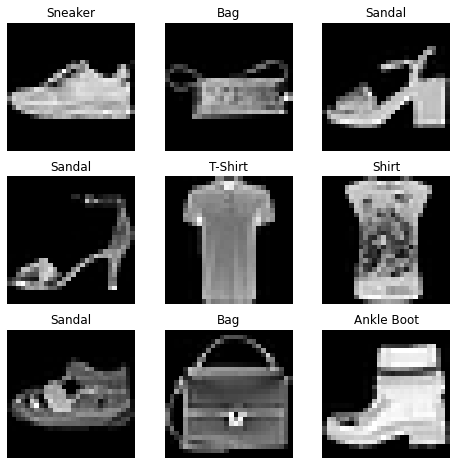

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 파일에서 사용자 정의 데이터셋 만들기
사용자 정의 Dataset클래스는 반드시 3개 함수를 구현해야 합니다. `__init__`, `__len__`, and `__getitem__`, 아래 구현을 살펴보면 FashionMNIST 이미지들은 `img_dir` 디렉토리에 저장되고, 정답은 `annotations_file` csv 파일에 별도로 저장됩니다.  
  
다음 장에서 각 함수들에서 일어나는 일들을 자세히 살펴보겠습니다.

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### `__init__`
`__init__` 함수는 Dataset 객체가 생성될 때 한 번만 실행됩니다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두가지 변형(transform)을 초기화합니다.  
  
labels.csv 파일은 다음과 같습니다.
```text
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

In [4]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### `__len__`
`__len__`함수는 데이터셋의 샘풀 개수를 반환합니다.

In [5]:
def __len__(self):
    return len(self.img_labels)

#### `__getitem__`
`__getitem__` 함수는 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image를 사용하여 이미지를 텐서로 변환하고, self.img_labels의 csv 데이터로부터 해당하는 정답을 가져오고, 변형함수들을 호출한 뒤, 텐서 이미지와 라벨을 python dict형으로 반환합니다.

In [6]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

## DataLoader로 학습용 데이터 준비하기
Dataset은 데이터셋의 특징을 가져오고 하나의 샘플에 정답을 지정하는 일을 한 번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 "미니배치"로 전달하고, 매 에폭마다 데이터를 다시 섞어서 과적합을 막고 python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 합니다.  
  
DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체입니다.

In [7]:
from torch.utils.data import DataLoader 

train_datalaoder = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### DataLoader를 통해 순회하기(iterate)
DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 아래의 각 순회는 (각 batch_size의 특징과 정답을 포함) train_features와 train_labels의 묶음을 반환합니다. shuffle로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.  
(데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제이하려면 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)를 살펴보세요) 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


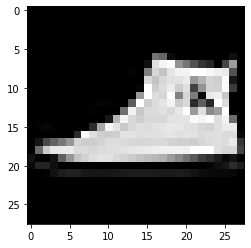

label: 7


In [8]:
# 이미지와 정답을 표시합니다.
train_features, train_labels = next(iter(train_datalaoder))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"label: {label}")